## Test All Things Flow for Stage 3 before training!

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import random
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from typing import Sequence, Dict, Union, List, Mapping, Any, Optional
import torch.utils.data as data
import numpy.typing as npt
from gqvr.dataset.utils import load_video_file_list, center_crop_arr, random_crop_arr, srgb_to_linearrgb, emulate_spc
from gqvr.utils.common import instantiate_from_config

/home/argar/miniconda3/envs/hypir/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Video Loader

In [2]:
class SPCVideoDataset(data.Dataset):
    """
        Dataset for finetuning the VAE's encoder and SPC-ControlNet Stages (independent of each other).
        Args:
            file_list (str): Path to the file list containing image paths and optionally prompts.
            file_backend_cfg (Mapping[str, Any]): Configuration for the file backend to load images.
            out_size (int): The output size of the images after cropping.
            crop_type (str): Type of cropping to apply to the images. Options are 'none', 'center', or 'random'.
        Returns:
            A dictionary containing:
                - 'gt': Ground truth image tensor of shape (C, H, W) with pixel values in the range [-1, 1].
                - 'lq': SPC image (dubbed as low-quality) tensor of shape (C, H, W) with pixel values in the range [-1, 1].
                - 'prompt': The prompt associated with the image.
    """
    def __init__(self,
                    file_list: str,
                    file_backend_cfg: Mapping[str, Any],
                    out_size: int,
                    crop_type: str,
                    use_hflip: bool) -> "SPCVideoDataset":

        super(SPCVideoDataset, self).__init__()
        self.file_list = file_list
        self.video_files = load_video_file_list(file_list)
        self.file_backend = instantiate_from_config(file_backend_cfg)
        self.out_size = out_size
        self.crop_type = crop_type
        self.use_hflip = use_hflip # No need for 1.5M big dataset
        assert self.crop_type in ["none", "center", "random"]
        self.HARDDISK_DIR = "/mnt/disks/behemoth/datasets/"


    def load_gt_images(self, video_path: str, max_retry: int = 5):
        gt_images = []
        # print(f"Loading GT video from {video_path}")
        for img_name in sorted(os.listdir(video_path)):
            image_path = os.path.join(video_path, img_name)
            # print(f"Loading {image_path}")
            image = Image.open(image_path).convert("RGB")
            # print(f"Loaded GT image size: {image.size}")
            if self.crop_type != "none":
                if image.height == self.out_size and image.width == self.out_size:
                    image = np.array(image)
                else:
                    if self.crop_type == "center":
                        image = center_crop_arr(image, self.out_size)
                    elif self.crop_type == "random":
                        image = random_crop_arr(image, self.out_size, min_crop_frac=0.7)
            else:
                assert image.height == self.out_size and image.width == self.out_size
                image = np.array(image)
            # hwc, rgb, 0,255, uint8
            gt_images.append(image)
        return np.stack(gt_images, axis=0) # thwc


    def generate_spc_from_gt(self, img_gt):
        if img_gt is None:
            return None
        img = srgb_to_linearrgb(img_gt / 255.)
        img = emulate_spc(img, 
                          factor=1.0 # Brightness directly proportional to this hparam. 1.0 => scene's natural lighting
                        )
        return img


    def convert_to_Nbit_spc(self, imgs_gt: npt.NDArray, bits: int = 3):
        N = 2**bits - 1
        imgs_lq = []
        for img_gt in imgs_gt:
            img_lq_sum = np.zeros_like(img_gt, dtype=np.float32)
            for i in range(N): # 4-bit (2**4 - 1)
                img_lq_sum = img_lq_sum + self.generate_spc_from_gt(img_gt)
            img_lq = img_lq_sum / (1.0*N)
            imgs_lq.append(img_lq)
        return np.stack(imgs_lq, axis=0) # thwc


    def __getitem__(self, index: int) -> Dict[str, Union[np.ndarray, str]]:
        # load gt image
        imgs_gt = None
        imgs_lq = None
        while imgs_gt is None and imgs_lq is None:
            # load meta file
            video_path = self.video_files[index]['video_path']
            gt_video_path =  self.HARDDISK_DIR + video_path[2:]
            # print("gt path:", gt_path)
            # print(f"Loading GT image from {gt_path}")
            prompt = self.video_files[index]['prompt']

            try:
                imgs_gt = self.load_gt_images(gt_video_path)
                # print(f"Loaded {imgs_gt.shape[0]} frames from {gt_video_path}")
            except Exception as e:
                print(e)
                print(f"Could not load: {gt_video_path}, setting a random index")
                index = random.randint(0, len(self) - 1)
                continue
            
            if imgs_gt is None:
                print(f"failed to load {gt_video_path} or generate lq image, try another image")
                index = random.randint(0, len(self) - 1)
                continue

            # NOTE: SPAD bit-resolution was changed permanently --- No need for 1-bit VAEs
            # However, to revert back... uncomment:
            # img_lq = self.generate_spc_from_gt(img_gt)
            # And comment the following
            
            spc_bits = 3 # bits
            imgs_lq = self.convert_to_Nbit_spc(imgs_gt, bits=spc_bits)


        # Shape: (t, h, w, c); channel order: RGB; image range: [0, 1], float32.
        imgs_gt = (imgs_gt / 255.0).astype(np.float32)
        imgs_lq = imgs_lq.astype(np.float32) # BUG-FIXED now!!! for all datasets img_lq is already [0,1], no need to divide by 255

        # if self.use_hflip and np.random.uniform() < 0.5:
        #     img_gt = np.fliplr(img_gt)
        #     img_lq = np.fliplr(img_lq)

        # Should lq be normalized to [-1,1] or stay in [0, 1] range? For now [-1, 1]
        gt = (imgs_gt * 2 - 1).astype(np.float32)
        # [-1, 1]
        lq = (imgs_lq * 2 - 1).astype(np.float32) 
        # print(np.amax(lq), np.amin(lq))
        return gt, lq, prompt, gt_video_path


    def __len__(self) -> int:
        return len(self.video_files)
    

In [3]:
dataset = SPCVideoDataset(
        file_list="/home/argar/apgi/gQVR/dataset_txt_files/udm10_video.txt",
        file_backend_cfg={"target": "gqvr.dataset.file_backend.HardDiskBackend"},
        out_size=512,
        crop_type="center",
        use_hflip=False,
    )
print(f"Complete Dataset length: {len(dataset)}")
sample = next(iter(dataset))
print(f"Sample GT shape: {sample[0].shape}, LQ shape: {sample[1].shape}, Prompt: {sample[2]}, Video Path: {sample[3]}")
print(f"GT Range: {np.amax(sample[0])} | {np.amin(sample[0])}")
print(f"SPC Range: {np.amax(sample[1])} | {np.amin(sample[1])}")

Complete Dataset length: 10
Sample GT shape: (32, 512, 512, 3), LQ shape: (32, 512, 512, 3), Prompt: , Video Path: /mnt/disks/behemoth/datasets/UDM10_video/006
GT Range: 1.0 | -1.0
SPC Range: 1.0 | -1.0


### Compute RAFT Flow & Viz (Using pipeline implemented code)

In [4]:
from gqvr.model.core_raft.raft import RAFT
from gqvr.model.core_raft.utils import flow_viz
from gqvr.model.core_raft.utils.utils import InputPadder
import argparse

use sdp attention as default
keep default attention mode


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
class RAFT_args:
    mixed_precision = False
    alternate_corr = False
    small = False
    dropout = False

raft_args = RAFT_args()
print(raft_args)

In [7]:
raft_model = RAFT(raft_args)
# print(raft_model)
# print("--------------------------------------------------------------------------")
raft_things_dict = torch.load("/home/argar/apgi/gQVR/pretrained_checkpoints/raft_models_weights/raft-things.pth")
corrected_state_dict = {}
for k, v in raft_things_dict.items():
    k2 = ".".join(k.split(".")[1:])
    corrected_state_dict[k2] = v
raft_model.load_state_dict(corrected_state_dict)
raft_model.eval().requires_grad_(False).to(device)

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

### Test Differentiable Warping & Viz

In [8]:
def differentiable_warp(x, flow):
    """
    Warp image or feature x according to flow.
    x: [B, C, H, W]
    flow: [B, 2, H, W] (flow in pixels, with flow[:,0] = dx, flow[:,1] = dy)
    """
    B, C, H, W = x.size()
    # Create mesh grid normalized to [-1,1]
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid = torch.stack((grid_x, grid_y), 2).float().to(x.device)  # [H, W, 2]

    grid = grid.unsqueeze(0).repeat(B, 1, 1, 1)  # [B, H, W, 2]

    # Add flow, normalize grid to [-1,1]
    flow = flow.permute(0, 2, 3, 1)
    new_grid = grid + flow
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (W - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (H - 1) - 1.0

    warped = F.grid_sample(x, new_grid, align_corners=True)
    return warped


def compute_flow_magnitude(flow):
    return torch.norm(flow, dim=1, keepdim=True)  # [B, 1, H, W]

def compute_flow_gradients(flow):
    # flow: [B, 2, H, W]
    fx = flow[:, 0:1, :, :]  # horizontal flow
    fy = flow[:, 1:2, :, :]  # vertical flow

    # finite difference gradients (simple Sobel or central differences)
    fx_du = fx[:, :, :, 2:] - fx[:, :, :, :-2]  # d/dx
    fx_dv = fx[:, :, 2:, :] - fx[:, :, :-2, :]  # d/dy

    fy_du = fy[:, :, :, 2:] - fy[:, :, :, :-2]
    fy_dv = fy[:, :, 2:, :] - fy[:, :, :-2, :]

    # pad to original size (pad 1 pixel on each side)
    fx_du = F.pad(fx_du, (1, 1, 0, 0))
    fx_dv = F.pad(fx_dv, (0, 0, 1, 1))
    fy_du = F.pad(fy_du, (1, 1, 0, 0))
    fy_dv = F.pad(fy_dv, (0, 0, 1, 1))

    return fx_du, fx_dv, fy_du, fy_dv

In [9]:
from gqvr.model.warp_utils import flow_to_rgb

In [27]:
gt, lq, prompt, vid_path = next(iter(dataset))
# print(gt.shape, lq.shape, prompt, vid_path)
f1_idx = 0
f2_idx = 4

frame1 = torch.Tensor(gt[f1_idx]).permute(2,0,1).unsqueeze(0).to(device)
frame2 = torch.Tensor(gt[f2_idx]).permute(2,0,1).unsqueeze(0).to(device)
# print(frame1.size(), frame2.size())

flow_fw, flow_bw = raft_model(frame1, frame2, iters=20, test_mode=True)

/home/argar/apgi/gQVR/gqvr/model/core_raft/raft.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/home/argar/apgi/gQVR/gqvr/model/core_raft/raft.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/home/argar/apgi/gQVR/gqvr/model/core_raft/raft.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


In [28]:
print(flow_fw.size())

torch.Size([1, 2, 64, 64])


In [29]:
rgb_flow_fw = flow_to_rgb(flow_fw.squeeze().permute(1,2,0).cpu().numpy())
rgb_flow_bq = flow_to_rgb(flow_bw.squeeze().permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


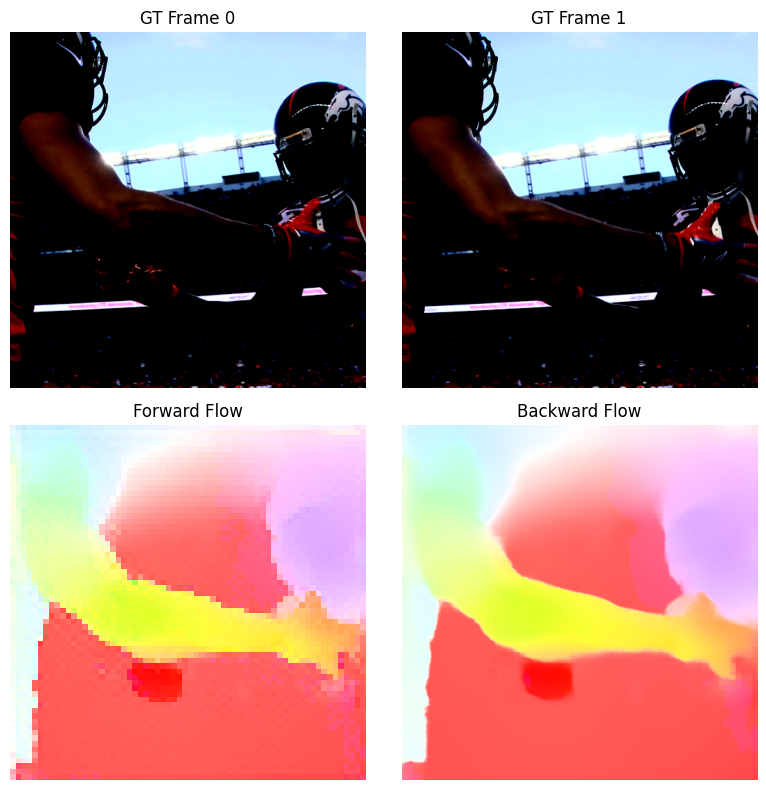

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(gt[f1_idx])
axs[0, 0].axis("off")
axs[0, 0].set_title("GT Frame 0")

axs[0, 1].imshow(gt[f2_idx])
axs[0, 1].axis("off")
axs[0, 1].set_title("GT Frame 1")

axs[1, 0].imshow(rgb_flow_fw)
axs[1, 0].axis("off")
axs[1, 0].set_title("Forward Flow")

axs[1, 1].imshow(rgb_flow_bq)
axs[1, 1].axis("off")
axs[1, 1].set_title("Backward Flow")

plt.tight_layout()
plt.show()

### Test Differentiable Occlusion Mask Detection

In [ ]:
def detect_occlusion(fw_flow, bw_flow, img):
    """
    fw_flow: forward flow from img1 to img2, [B, 2, H, W]
    bw_flow: backward flow from img2 to img1, [B, 2, H, W]
    img: image tensor (for warping), [B, C, H, W]

    Returns:
        occlusion mask [B, 1, H, W], float tensor (0 or 1 mask)
        warped_img2: img warped back to img1 space by bw_flow
    """

    # Warp forward flow to img2 frame using backward flow
    fw_flow_warped = differentiable_warp(fw_flow, bw_flow)  # [B, 2, H, W]

    # Warp img to img1 space using backward flow
    warp_img = differentiable_warp(img, bw_flow)

    # Forward-backward flow consistency check
    fb_flow_sum = fw_flow_warped + bw_flow  # should be near zero if consistent

    fb_flow_mag = compute_flow_magnitude(fb_flow_sum)  # [B,1,H,W]
    fw_flow_w_mag = compute_flow_magnitude(fw_flow_warped)
    bw_flow_mag = compute_flow_magnitude(bw_flow)

    threshold = 0.01 * (fw_flow_w_mag + bw_flow_mag) + 0.5

    mask1 = fb_flow_mag > threshold  # bool mask [B,1,H,W]

    # Compute flow gradients for motion boundary detection
    fx_du, fx_dv, fy_du, fy_dv = compute_flow_gradients(bw_flow)
    fx_mag = fx_du ** 2 + fx_dv ** 2
    fy_mag = fy_du ** 2 + fy_dv ** 2

    mask2 = (fx_mag + fy_mag) > 0.01 * bw_flow_mag + 0.002

    # Combine masks
    mask = mask1 | mask2  # logical or

    occlusion = mask.float()  # convert to float mask (0 or 1)

    return occlusion, warp_img

### Is Differentiable Warp loss ~= E*_warp loss?

In [6]:
def compute_flow_loss(pred_frames, gt_frames):
    B, T, C, H, W = pred_frames.shape
    loss = 0.0
    for i in range(T - 1):
        frame1 = pred_frames[:, i, ...]
        frame2 = gt_frames[:, i+1, ...]
        # Compute forward and backward flow using RAFT
        flow_fw, flow_bw = self.raft_model(frame1, frame2, iters=20, test_mode=True)
        # Differentiable Warp gt frame (t+1) to pred frame (t)
        warp_img2 = differentiable_warp(frame2, flow_fw)
        # Differentiable Compute occlusion mask 
        occ_mask, _ = detect_occlusion(flow_fw, flow_bw)
        noc_mask = 1 - occ_mask
        diff = (warp_img2 - frame1) * noc_mask
        diff_squared = diff ** 2
        N = torch.sum(noc_mask)
        N = torch.clamp(N, min=1.0)
        err += torch.sum(diff_squared) / N
    warping_error = err / (T - 1)
    return warping_error